In [6]:
# General
import xarray as xr    # handles netcdf data
import numpy as np     # numerical functions etc
import pandas as pd    # dataframes
import matplotlib      # plotting functions
import matplotlib.pyplot as plt    # specific plotting function I use a lot   
from matplotlib.patches import Rectangle     # specific plotting function with an annoyingly long name
import matplotlib.gridspec as gridspec #to define the sizes of plots specifically
import geopandas as gpd    # shapefiles
import cartopy     # plotting geographical features
from shapely.geometry import MultiPolygon, Polygon #to deal with 3D polygons
import regionmask    # convert shapefile to binary 0,1 mask
import re     # regular expressions (replace substrings etc)
from geopy.geocoders import Nominatim    # get lat & lon coordinates from a place name

#for climate indices
import xclim.indices as xc_i
import xclim as xc

#For plotting
import matplotlib.ticker as plticker
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import nc_time_axis #to plot cf.time axis
import cftime #to plot cf.time axis

#For Statistics
import scipy.stats as stats
from scipy import optimize
from xclim.indices.stats import fit
from scipy.stats import norm, gamma
import lmoments3.distr                     # conda activate xclim; pip install git+https://github.com/OpenHydrology/lmoments3.git
glo = getattr(lmoments3.distr, "glo")

#For copulas
import sklarpy.univariate as sk_uni
from sklarpy.copulas import gh_copula
from sklarpy.multivariate import mvt_normal
from sklarpy.copulas import MarginalFitter
from sklarpy.univariate import UnivariateFitter
from sklarpy import print_full
from sklarpy.copulas import gumbel_copula
from sklarpy.copulas import frank_copula
from sklarpy.copulas import clayton_copula

#For handling errors
import sys
import warnings

## Necessary Functions:

In [7]:
def new_get_nSPEI(eff_pr, months = range(1,13), calibration_period = slice("1980", "2010")):
    '''
    Summary:
    -----------
    Computes a the monthly SPEI value. 
    
    Parameters:
    -----------
    eff_pr: xarray DataArray object 
            - Effective Precipitation / Water Balance, defined via Precipitation - Potential Evapotranspiration
            - must be a DataArray with a time dimension labelled as a DateTime object
         
    months: range object
            - describing the months of the year for which the SPEI value should be calculated
             
    calibration_period: slice object
            - describing the calibration timeperiod, needs to be within the dataset
         
    Returns:
    ----------
    spei: xarray DataArray oject
            - The SPEI values              
    '''

    ## NB CURRENTLY NOTHING IN PLACE TO HANDLE DRY PERIODS IN THE TIME SERIES - USE WITH CAUTION!
    
    # create empty list to hold results
    spei_monthly = []
    # fit each calendar month in turn
    for m in months:    
        # select current calendar month
        epr_m = eff_pr.sel(time = eff_pr.time.dt.month == m)     
        # estimate parameters over calibration period (PWM seems to give more robust fit, so using xclim fit method - also applies over whole spatial array)
        epr_cal = epr_m.sel(time = calibration_period).copy()    
        # fit parameters for whole map (has to be done manually due to bug in xclim)
        pars = xr.apply_ufunc(lambda x : np.asarray(list(glo.lmom_fit(x.copy()).values())), epr_cal,
                              input_core_dims = [["time"]], output_core_dims = [["dparams"]], vectorize = True).assign_coords(dparams = ["k", "loc", "scale"])    
        # running without dry-month normalisation for now - check if needed for this dataset
        spei_m = xr.apply_ufunc(lambda pr, dparams : norm.ppf(glo.cdf(pr, *dparams)), epr_m, pars, 
                                input_core_dims=[["time"],["dparams"]], output_core_dims=[["time"]], vectorize = True).assign_coords(time = epr_m.time)
        # replace +ve (-ve) infinite values with finite maximum (minimum) in each grid cell
        spei_finite = xr.concat([spei_m.where(~np.isinf(spei_m)), 
                                 xr.ones_like(spei_m).where(spei_m == np.inf) * spei_m.where(spei_m < np.inf).max("time"),
                                 xr.ones_like(spei_m).where(spei_m == -np.inf) * spei_m.where(spei_m > -np.inf).min("time")], "new").sum("new").copy()
        spei_monthly.append(spei_finite) 

    # concatenate monthly fitted values, reorder & relabel
    spei = xr.concat(spei_monthly, "time").sortby("time").rename("spei")  
    # clean out existing attributes and replace with new variable description
    for k in list(spei.attrs.keys()): del spei.attrs[k]
    spei = spei.assign_attrs(notes = "Calibrated against "+str(calibration_period.start)+"-"+str(calibration_period.stop))
    spei = spei.where(~np.isnan(eff_pr)).dropna("time", "all")
    
    # Replace exactly zero values with linear interpolation as these are fit-failures
    zero_mask = (spei == 0)
    spei_zero_filled = spei.where(~zero_mask)  # keep non-zero values as they are
    spei_interpolated = spei_zero_filled.interpolate_na(dim="time", method="linear")
    
    # Combine the interpolated values back into the original array, but only for positions where spei was zero
    spei = xr.where(zero_mask, spei_interpolated, spei)

    return spei

def mse_2(num_parameters, predictions, targets):
    '''
    Summary:
    -----------
    Computes the Mean Square Error (MSE). 
    
    Parameters:
    -----------
    num_parameters: float
            - number of parameters used in representing the fitted distribution
            
    predictions: Array object 
            - Contains the predicted values
         
    targets: Array object
            - Containts the observational, target values
         
    Returns:
    ----------
    mse: float
            - Value representing the Mean Square Error              
    '''
    n = len(predictions)
    mse = ((predictions - targets) ** 2).sum()/(n - num_parameters)
    return mse

def aic(num_parameters,loglikelihood_discret):
    '''
    Summary:
    -----------
    Computes the Akaike Information Criterion (AIC). 
    
    Parameters:
    -----------
    loglikelihood_discret: scipy obejct
            - containt the .logpdf object of the respecitve distribtution which is evaluated
            
    predictions: Array object 
            - Contains the predicted values, namely the CDF of the fitted parameters
         
    Returns:
    ----------
    aic: float
            - Value representing the Akaike Information Criterion              
    '''
    
    loglikelihood_discret_sum = loglikelihood_discret.sum()
    aic = 2 * num_parameters - 2 * loglikelihood_discret_sum
    return aic

def cdf_estimator_test(fitted_copula,num_repeat):
    '''
    Summary:
    -----------
    Computes the Capéraá-Fougéres-Genest (CFG) estimator. 
    
    Parameters:
    -----------
    fitted_copula: sklarpy Object
            - sklarpy object which represents the fitted copula 
            
    num_repeat: Float
            - Contains the number of repetitions used to calculate the average
         
    Returns:
    ----------
    lambda_arr_mean: float
            - Value representing the Capéraá-Fougéres-Genest (CFG) estimator              
    '''
    #create array with length of repetition
    lambda_arr = np.zeros(num_repeat)
    
    #for-loop with the number of repetitions
    for t in np.arange(0,num_repeat,1):
        #define how many samples should be created
        n=1000

        #create sample of copula
        sample=fitted_copula.copula_rvs(n)

        #get the sum value
        sum_temp=0
        
        for i in np.arange(0,n,1):
            max_value = max(sample[i][0],sample[i][1])
            sum_temp += np.log(np.sqrt(np.log(1/sample[i][0])*np.log(1/sample[i][1]))/np.log(1/(max_value**2)))

        #rest of formula
        lambda_U_cfg = 2 - 2*np.exp(1/n*sum_temp)
        
        #Update array
        lambda_arr[t]=lambda_U_cfg

    #get mean on array
    lambda_arr_mean = lambda_arr.mean()
    return lambda_arr_mean

def get_SPEI_Duration_and_Severity_RunTheory(spei,threshold_drought=-0.8,threshold_minor=-1.5,threshold_combining=1):
    '''
    Summary:
    -----------
    Function which calculates the Severity-Duration pairs for a given SPEI timeseries. 
    
    Parameters:
    -----------
    spei: xarray DataArray oject
            - Timeseries containing the spei values
            
    threshold_drought: float 
            - Threshold representing the onset of a drought event
         
    threshold_minor: float 
            - Threshold representing the minium spei value for a 1-month event to be considered a drought
    
    threshold_combining: float 
            - Threshold representing the minium spei value which needs to be exceeded that two drought events which
            are separated by only one month to be considered individual events
         
    Returns:
    ----------
    Duration: Array
            - Values representing the Duration of the Drought events      
        
    Severity: Array
            - Values representing the Severity of the Drought events   
    '''
    
    #Set-up Array
    duration=[]
    severity=[]
    
    D=0
    S=0
    for t in np.arange(0,len(spei),1):
        #Drought Condition
        if spei[t]<threshold_drought:
            D=D+1
            S=S+spei[t]
            
        #To take the case into account if last value is just one month -> ongoing heatwave, 
        #only when last severity is lower than threshold_combining and severity of event larger than threshold_minor!
        elif spei[t-1]<threshold_drought and t==len(spei)-1 and spei[t]<threshold_combining and spei[t] < threshold_minor:
            D=D+1
            S=S
            
        #The condition before corrected for the last loop
        elif t!=len(spei)-1 and spei[t-1]<threshold_drought and spei[t+1]<threshold_drought and spei[t]<threshold_combining:
            D=D+1
            S=S
        
        #If the spei value is above the threshold and none of the conditions above apply that drought event is over
        else:
            duration.append(D )
            D=0
            severity.append(S)
            S=0

    #to get values if the drought ends in the loop
    duration.append(D)
    severity.append(S)
    
    #remove all durations of 1 if Severity is less than threshold (here set to: -1.5) 
    for i in np.arange(0,len(duration),1):
        if duration[i] == 1:
            if severity[i] > threshold_minor:
                duration[i] = 0
                severity[i] = 0
                
    #Remove all 0 and define severity positive
    duration = np.array(duration)
    duration = duration[duration>0]
    
    severity = np.array(severity)
    severity = -severity
    severity = severity[severity>0]      
    
    return duration, severity

## Load in the Data

In [8]:
#This line should point to the era5 data directory
dir_data = '/rds/general/user/nmerz/home/MSc_Diss/data/AR6_regions/obs/era5/'
model_name = 'era5'

### Load Regions

In [9]:
#This line is necessary to obtain the longitude and latitude
fn_tmin = '/rds/general/user/nmerz/home/MSc_Diss/data/AR6_regions/obs/era5/model_data/era5_tmin_daily_275-330E_15--60N_su.nc'
ds_tmin = xr.open_dataset(fn_tmin).sel(time=slice("1950","2023"))
era5_tmin = ds_tmin.tmin

sf_all = gpd.read_file("/rds/general/user/nmerz/home/MSc_Diss/data/AR6_regions/shapefile").to_crs(cartopy.crs.PlateCarree())
sf_SA = sf_all[sf_all['Acronym'].str.contains("NWS|NSA|NES|SAM|SWS|SES|SSA")]
rm_SA = regionmask.mask_3D_geopandas(sf_SA, era5_tmin.lon, era5_tmin.lat).squeeze(drop = True)
sf_9 = sf_all[sf_all['Acronym'].str.contains("NWS")]
rm_9 = regionmask.mask_3D_geopandas(sf_9, era5_tmin.lon, era5_tmin.lat).squeeze(drop = True)
sf_10 = sf_all[sf_all['Acronym'].str.contains("NSA")]
rm_10 = regionmask.mask_3D_geopandas(sf_10, era5_tmin.lon, era5_tmin.lat).squeeze(drop = True)
sf_11 = sf_all[sf_all['Acronym'].str.contains("NES")]
rm_11 = regionmask.mask_3D_geopandas(sf_11, era5_tmin.lon, era5_tmin.lat).squeeze(drop = True)
sf_12 = sf_all[sf_all['Acronym'].str.contains("SAM")]
rm_12 = regionmask.mask_3D_geopandas(sf_12, era5_tmin.lon, era5_tmin.lat).squeeze(drop = True)
sf_13 = sf_all[sf_all['Acronym'].str.contains("SWS")]
rm_13 = regionmask.mask_3D_geopandas(sf_13, era5_tmin.lon, era5_tmin.lat).squeeze(drop = True)
sf_14 = sf_all[sf_all['Acronym'].str.contains("SES")]
rm_14 = regionmask.mask_3D_geopandas(sf_14, era5_tmin.lon, era5_tmin.lat).squeeze(drop = True)
sf_15 = sf_all[sf_all['Acronym'].str.contains("SSA")]
rm_15 = regionmask.mask_3D_geopandas(sf_15, era5_tmin.lon, era5_tmin.lat).squeeze(drop = True)

In [10]:
fn_spei_M1_9 = dir_data + 'nSPEI_HG85_cal1980_2010/spei_M6_9.nc'
spei_M1_raw_9 = xr.open_dataset(fn_spei_M1_9)
spei_M1_9 = spei_M1_raw_9.spei
spei_M1_arr_9 = spei_M1_9.to_numpy()
time_spei_M1_arr_9 = spei_M1_9.time.to_numpy()
spei_M1_arr_pos_9 = spei_M1_arr_9>=0
spei_M1_arr_neg_9 = spei_M1_arr_9<=0
fn_spei_M1_10 = dir_data + 'nSPEI_HG85_cal1980_2010/spei_M6_10.nc'
spei_M1_raw_10 = xr.open_dataset(fn_spei_M1_10)
spei_M1_10 = spei_M1_raw_10.spei
spei_M1_arr_10 = spei_M1_10.to_numpy()
time_spei_M1_arr_10 = spei_M1_10.time.to_numpy()
spei_M1_arr_pos_10 = spei_M1_arr_10>=0
spei_M1_arr_neg_10 = spei_M1_arr_10<=0
fn_spei_M1_11 = dir_data + 'nSPEI_HG85_cal1980_2010/spei_M6_11.nc'
spei_M1_raw_11 = xr.open_dataset(fn_spei_M1_11)
spei_M1_11 = spei_M1_raw_11.spei
spei_M1_arr_11 = spei_M1_11.to_numpy()
time_spei_M1_arr_11 = spei_M1_11.time.to_numpy()
spei_M1_arr_pos_11 = spei_M1_arr_11>=0
spei_M1_arr_neg_11 = spei_M1_arr_11<=0
fn_spei_M1_12 = dir_data + 'nSPEI_HG85_cal1980_2010/spei_M6_12.nc'
spei_M1_raw_12 = xr.open_dataset(fn_spei_M1_12)
spei_M1_12 = spei_M1_raw_12.spei
spei_M1_arr_12 = spei_M1_12.to_numpy()
time_spei_M1_arr_12 = spei_M1_12.time.to_numpy()
spei_M1_arr_pos_12 = spei_M1_arr_12>=0
spei_M1_arr_neg_12 = spei_M1_arr_12<=0
fn_spei_M1_13 = dir_data + 'nSPEI_HG85_cal1980_2010/spei_M6_13.nc'
spei_M1_raw_13 = xr.open_dataset(fn_spei_M1_13)
spei_M1_13 = spei_M1_raw_13.spei
spei_M1_arr_13 = spei_M1_13.to_numpy()
time_spei_M1_arr_13 = spei_M1_13.time.to_numpy()
spei_M1_arr_pos_13 = spei_M1_arr_13>=0
spei_M1_arr_neg_13 = spei_M1_arr_13<=0
fn_spei_M1_14 = dir_data + 'nSPEI_HG85_cal1980_2010/spei_M6_14.nc'
spei_M1_raw_14 = xr.open_dataset(fn_spei_M1_14)
spei_M1_14 = spei_M1_raw_14.spei
spei_M1_arr_14 = spei_M1_14.to_numpy()
time_spei_M1_arr_14 = spei_M1_14.time.to_numpy()
spei_M1_arr_pos_14 = spei_M1_arr_14>=0
spei_M1_arr_neg_14 = spei_M1_arr_14<=0
fn_spei_M1_15 = dir_data + 'nSPEI_HG85_cal1980_2010/spei_M6_15.nc'
spei_M1_raw_15 = xr.open_dataset(fn_spei_M1_15)
spei_M1_15 = spei_M1_raw_15.spei
spei_M1_arr_15 = spei_M1_15.to_numpy()
time_spei_M1_arr_15 = spei_M1_15.time.to_numpy()
spei_M1_arr_pos_15 = spei_M1_arr_15>=0
spei_M1_arr_neg_15 = spei_M1_arr_15<=0

### Region 10

In [11]:
#Define the array for calcultion
index = spei_M1_arr_10
index_name = 'spei_M1_arr_10'

#Set Plots true or false to plot duration-severity pairs and univariate Fitting curves:
plotter=True

#Calculating the Pairs
D_spei_histnat, S_spei_histnat = get_SPEI_Duration_and_Severity_RunTheory(index)

#Creating pd.array      
Duration = pd.Series(D_spei_histnat, name='Duration')
Severity = pd.Series(S_spei_histnat, name='Severity')
D_S_array = pd.concat([Duration, Severity], axis=1)
       
#Fitting Duration
x_D = np.linspace(0, D_S_array['Duration'].max(), 100)
#Exponential
expon = stats.expon
param_expon_D = expon.fit(D_S_array['Duration'],floc=0)
cdf_fitted_expon_D = expon.cdf(x_D, *param_expon_D)
pdf_fitted_expon_D = expon.pdf(x_D, *param_expon_D)
fitted_expon_D = sk_uni.expon.fit(D_S_array['Duration'],param_expon_D)
#Gamma
gamma = stats.gamma
param_gamma_D = gamma.fit(D_S_array['Duration'],floc=0)
cdf_fitted_gamma_D = gamma.cdf(x_D, *param_gamma_D)
pdf_fitted_gamma_D = gamma.pdf(x_D, *param_gamma_D)
fitted_gamma_D = sk_uni.gamma.fit(D_S_array['Duration'],param_gamma_D)
#Lognorm
lognorm = stats.lognorm
param_lognorm_D = lognorm.fit(D_S_array['Duration'],floc=0)
cdf_fitted_lognorm_D = lognorm.cdf(x_D, *param_lognorm_D)
pdf_fitted_lognorm_D = lognorm.pdf(x_D, *param_lognorm_D)
fitted_lognorm_D = sk_uni.lognorm.fit(D_S_array['Duration'],param_lognorm_D)
#Weibull
weibull = stats.weibull_min
param_weibull_D = weibull.fit(D_S_array['Duration'],floc=0)
cdf_fitted_weibull_D = weibull.cdf(x_D, *param_weibull_D)
pdf_fitted_weibull_D = weibull.pdf(x_D, *param_weibull_D)
fitted_weibull_D = sk_uni.weibull_min.fit(D_S_array['Duration'],param_weibull_D)
      
#Calculating important metrics for the testing
weights_D = np.ones_like(D_S_array['Duration'])/float(len(D_S_array['Duration']))
bins_D=np.arange(1, max(D_S_array['Duration']) + 2, 1)
number_bins_D = len(bins_D)
count_D, bins_count_D = np.histogram(D_S_array['Duration'], bins=bins_D,weights=weights_D)
bins_count_D = bins_count_D[:-1]
cdf_D = np.cumsum(count_D)

#Doing the same for Severity fits
x_S = np.linspace(0, D_S_array['Severity'].max(), 100)
#Exponential
expon = stats.expon
param_expon_S = expon.fit(D_S_array['Severity'],floc=0)
cdf_fitted_expon_S = expon.cdf(x_S, *param_expon_S)
fitted_expon_S = sk_uni.expon.fit(D_S_array['Severity'],param_expon_S)
#Gamma
gamma = stats.gamma
param_gamma_S = gamma.fit(D_S_array['Severity'],floc=0)
cdf_fitted_gamma_S = gamma.cdf(x_S, *param_gamma_S)
fitted_gamma_S = sk_uni.gamma.fit(D_S_array['Severity'],param_gamma_S)
#Lognorm
lognorm = stats.lognorm
param_lognorm_S = lognorm.fit(D_S_array['Severity'],floc=0)
cdf_fitted_lognorm_S = lognorm.cdf(x_S, *param_lognorm_S)
fitted_lognorm_S = sk_uni.lognorm.fit(D_S_array['Severity'],param_lognorm_S)
#Weibull
weibull = stats.weibull_min
param_weibull_S = weibull.fit(D_S_array['Severity'],floc=0)
cdf_fitted_weibull_S = weibull.cdf(x_S, *param_weibull_S)
fitted_weibull_S = sk_uni.weibull_min.fit(D_S_array['Severity'],param_weibull_S)
      
#The next step only works if there are no doubles, check if there are doubles:
if len(D_S_array['Severity']) != len(np.unique(D_S_array['Severity'])):
    print("Doubles!!!!!")
    sys.exit("Error message")

#Get CDF
weights_S = np.ones_like(D_S_array['Severity'])/float(len(D_S_array['Severity']))
cdf_histogram_S = np.zeros(len(D_S_array['Severity'])+1)
for i in np.arange(1,len(D_S_array['Severity']),1):
    cdf_histogram_S[i] = cdf_histogram_S[i-1] + weights_S[0]
cdf_histogram_S[-1] = cdf_histogram_S[-2] + weights_S[0]
cdf_histogram_S_xval = np.append(np.array([0]),np.unique(D_S_array['Severity']))
Severity_unique = np.unique(D_S_array['Severity'])

#Get PDF
bins_S=np.arange(np.ceil(min(D_S_array['Severity'])), np.ceil(max(D_S_array['Severity'])) + 2, 1)
number_bins_S = len(bins_D)
count_S, bins_count_S = np.histogram(D_S_array['Severity'], bins=bins_D/2,weights=weights_S/2)
bins_count_S = bins_count_S[:-1]

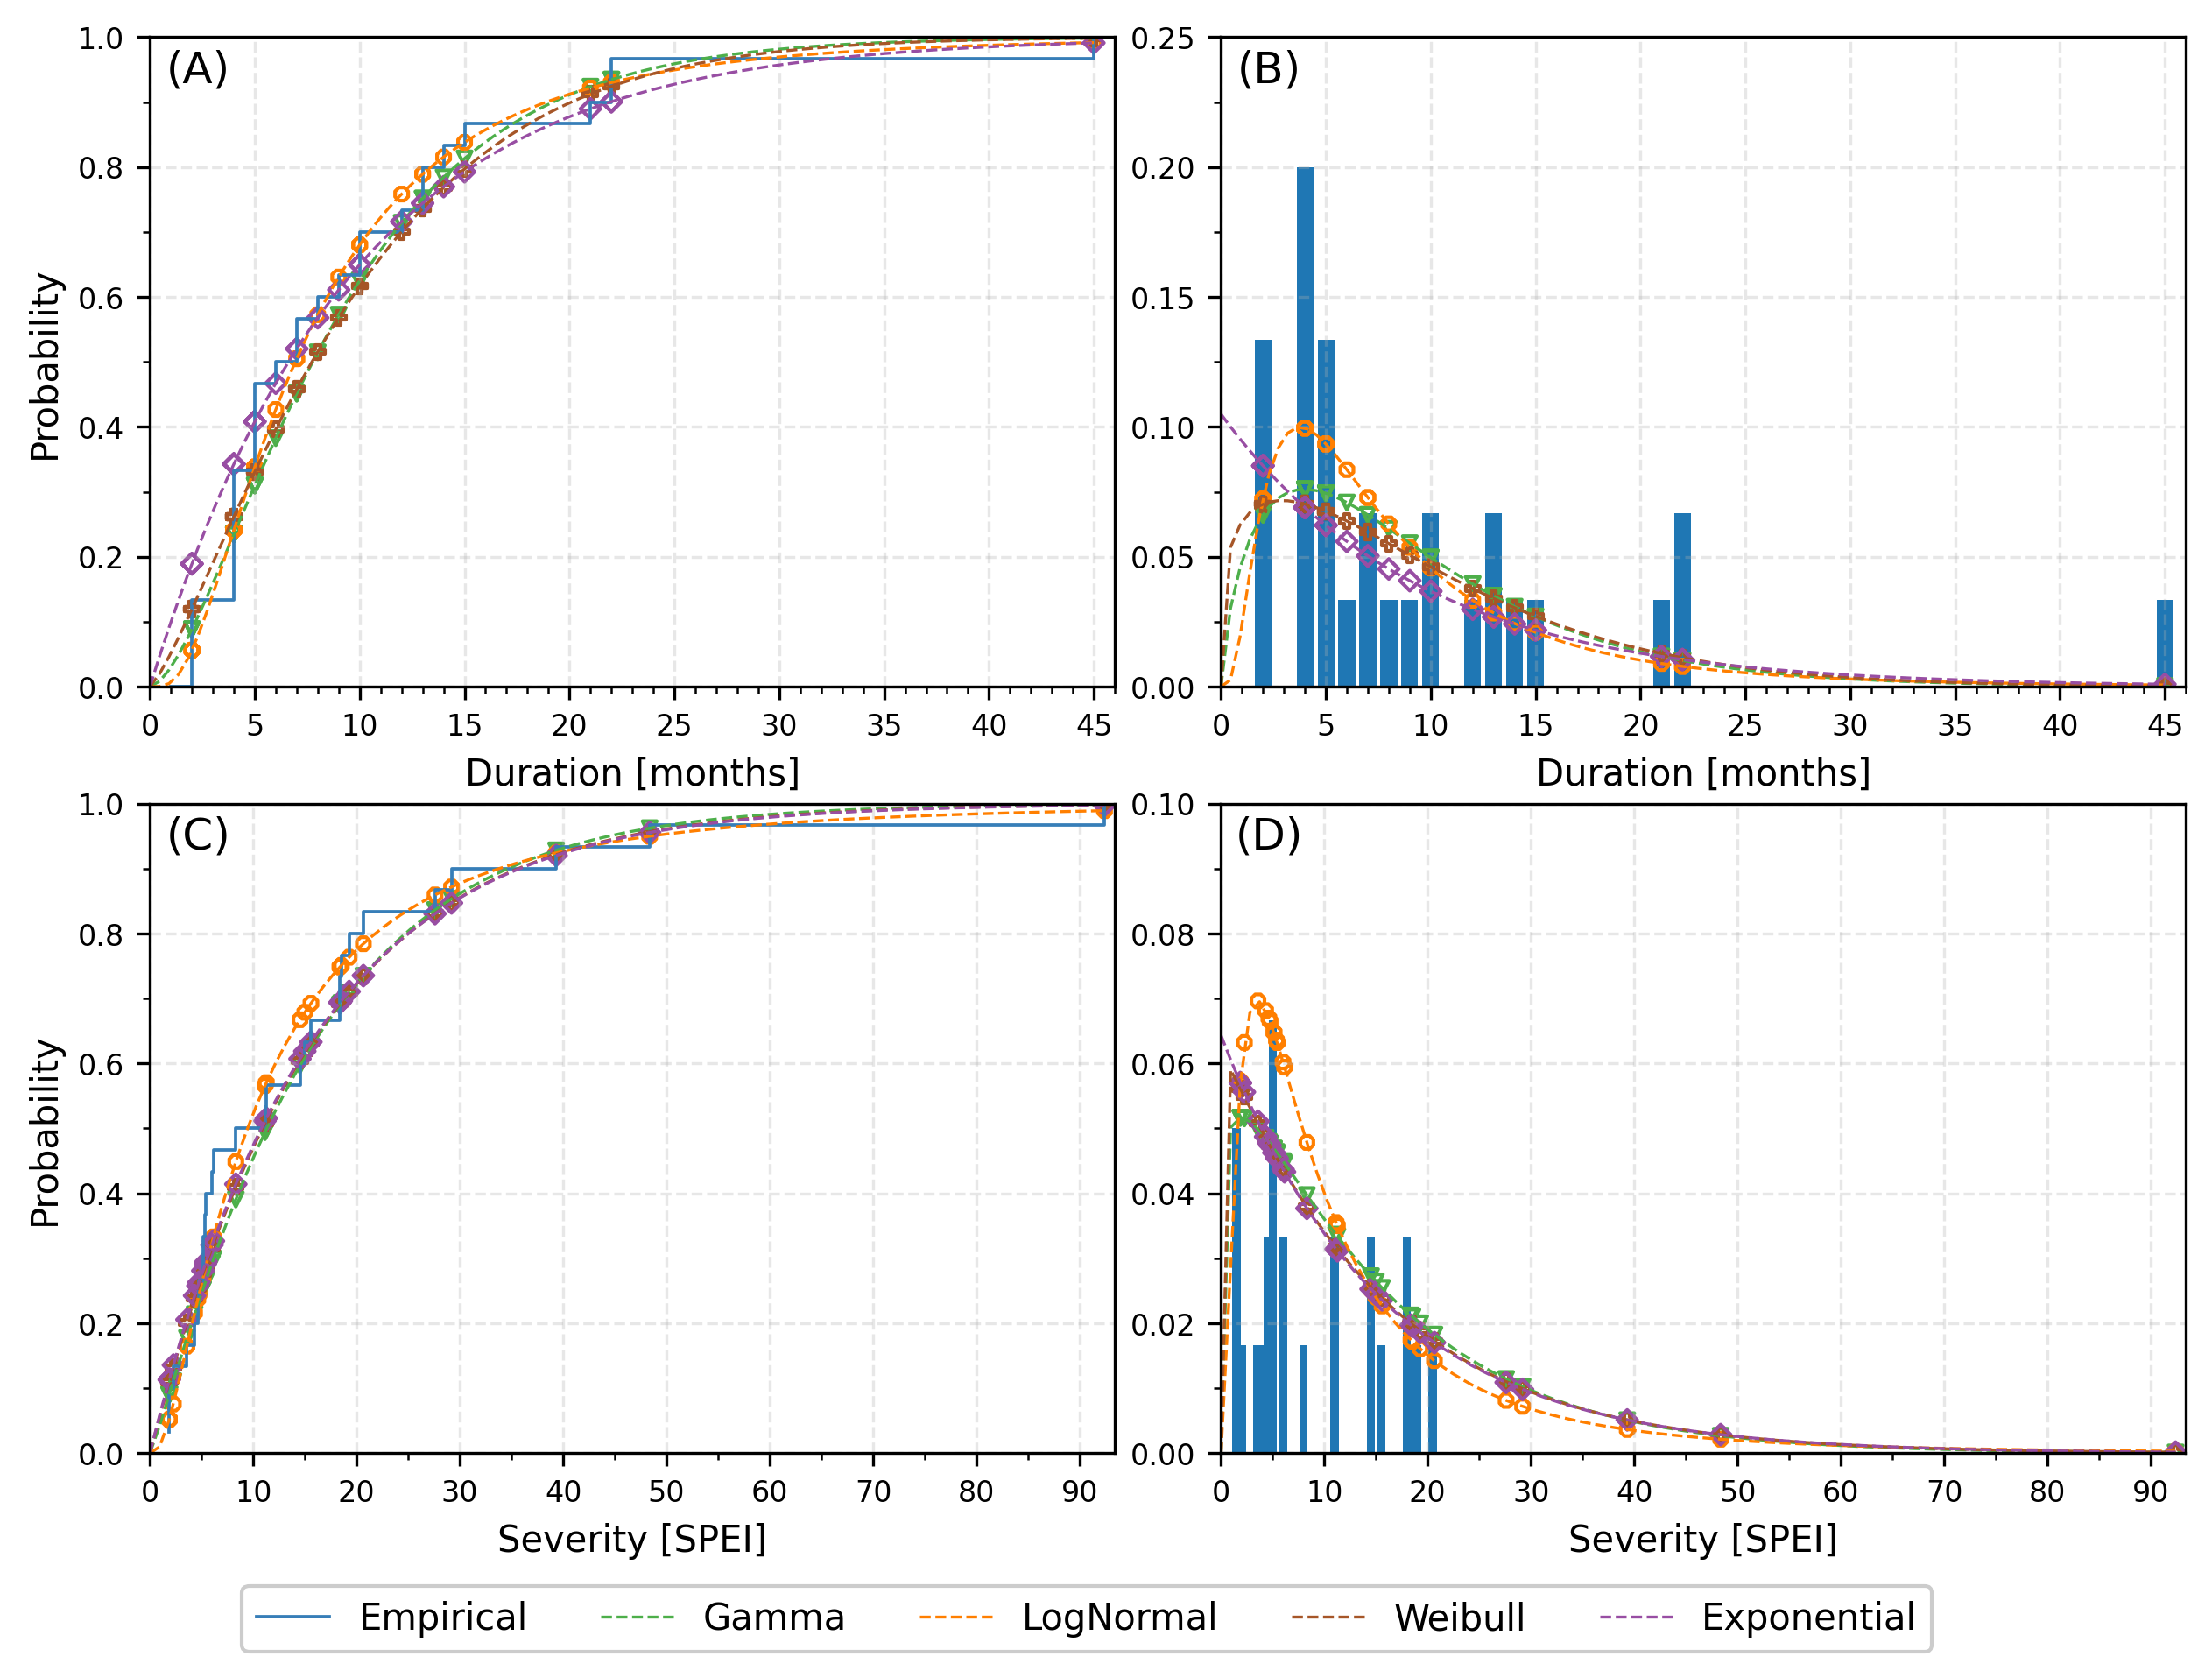

In [12]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,7), dpi = 300)
fig.subplots_adjust(wspace=0.11)
fig.subplots_adjust(hspace=0.18)

ax[0][0].step(bins_count_D[:],cdf_D,color='#377eb8',label=r'Empirical',where='post',lw=0.9)
ax[0][0].plot(x_D, cdf_fitted_gamma_D, color='#4daf4a',label=r'Gamma',ls='--',lw=0.8)
ax[0][0].scatter(D_S_array['Duration'],gamma.cdf(D_S_array['Duration'], *param_gamma_D),s=15,color='#4daf4a',marker="v",facecolors='none')
ax[0][0].plot(x_D, cdf_fitted_lognorm_D, color='#ff7f00',label=r'LogNormal',ls='--',lw=0.8)
ax[0][0].scatter(D_S_array['Duration'],lognorm.cdf(D_S_array['Duration'], *param_lognorm_D),s=15,color='#ff7f00',marker="8",facecolors='none')
ax[0][0].plot(x_D, cdf_fitted_weibull_D, color='#a65628',label=r'Weibull',ls='--',lw=0.8)
ax[0][0].scatter(D_S_array['Duration'],weibull.cdf(D_S_array['Duration'], *param_weibull_D),s=15,color='#a65628',marker="P",facecolors='none')
ax[0][0].plot(x_D, cdf_fitted_expon_D, color='#984ea3',label=r'Exponential',ls='--',lw=0.8)
ax[0][0].scatter(D_S_array['Duration'],expon.cdf(D_S_array['Duration'], *param_expon_D),s=15,color='#984ea3',marker="D",facecolors='none')
ax[0][0].set_xlim(0, D_S_array['Duration'].max()+1)
ax[0][0].set_ylim(0,1.00)
ax[0][0].xaxis.set_major_locator(MultipleLocator(5))# defines setting of the small ticks
ax[0][0].xaxis.set_minor_locator(MultipleLocator(1))# defines setting of the small ticks
ax[0][0].yaxis.set_minor_locator(MultipleLocator(.1))# defines setting of the small ticks
#legend0 = ax[0][0].legend(loc="lower right",fontsize='10')
#legend0.get_frame().set_alpha(0.5)
#legend0.get_frame().set_alpha(None)
ax[0][0].set_xlabel(r'Duration [months]',fontsize='10')
ax[0][0].set_ylabel(r'Probability',fontsize='10')
ax[0][0].tick_params(axis='both', which='major', labelsize='8')
ax[0][0].grid(True,alpha=0.3,linestyle = 'dashed')

ax[0][1].bar(bins_count_D,count_D)
ax[0][1].plot(x_D, pdf_fitted_gamma_D, color='#4daf4a',ls='--',lw=0.8)
ax[0][1].scatter(D_S_array['Duration'],gamma.pdf(D_S_array['Duration'], *param_gamma_D),s=15,color='#4daf4a',marker="v",facecolors='none')
ax[0][1].plot(x_D, pdf_fitted_lognorm_D, color='#ff7f00',ls='--',lw=0.8)
ax[0][1].scatter(D_S_array['Duration'],lognorm.pdf(D_S_array['Duration'], *param_lognorm_D),s=15,color='#ff7f00',marker="8",facecolors='none')
ax[0][1].plot(x_D, pdf_fitted_weibull_D, color='#a65628',ls='--',lw=0.8)
ax[0][1].scatter(D_S_array['Duration'],weibull.pdf(D_S_array['Duration'], *param_weibull_D),s=15,color='#a65628',marker="P",facecolors='none')
ax[0][1].plot(x_D, pdf_fitted_expon_D, color='#984ea3',ls='--',lw=0.8)
ax[0][1].scatter(D_S_array['Duration'],expon.pdf(D_S_array['Duration'], *param_expon_D),s=15,color='#984ea3',marker="D",facecolors='none')
ax[0][1].set_xlim(0, D_S_array['Duration'].max()+1)
ax[0][1].set_ylim(0,0.25)
ax[0][1].xaxis.set_major_locator(MultipleLocator(5))# defines setting of the small ticks
ax[0][1].xaxis.set_minor_locator(MultipleLocator(1))# defines setting of the small ticks
ax[0][1].yaxis.set_major_locator(MultipleLocator(.05))# defines setting of the small ticks
ax[0][1].yaxis.set_minor_locator(MultipleLocator(.025))# defines setting of the small ticks
# reordering the labels 
#handles, labels = ax[0][1].get_legend_handles_labels()
# specify order 
#order = [4, 0, 1, 2, 3] 
# pass handle & labels lists along with order as below 
#legend1 = ax[0][1].legend([handles[i] for i in order], [labels[i] for i in order],loc="upper right",fontsize='10')
#legend1.get_frame().set_alpha(0.5)
#legend1.get_frame().set_alpha(None)
ax[0][1].set_xlabel(r'Duration [months]',fontsize='10')
#ax[0][1].set_ylabel(r'Probability',fontsize='10')
ax[0][1].tick_params(axis='both', which='major', labelsize='8')
ax[0][1].grid(True,alpha=0.3,linestyle = 'dashed')

ax[1][0].step(cdf_histogram_S_xval[1:],cdf_histogram_S[1:],color='#377eb8',where='post',lw=0.9)
ax[1][0].plot(x_S, cdf_fitted_gamma_S, color='#4daf4a',ls='--',lw=0.8)
ax[1][0].scatter(D_S_array['Severity'],gamma.cdf(D_S_array['Severity'], *param_gamma_S),s=15,color='#4daf4a',marker="v",facecolors='none')
ax[1][0].plot(x_S, cdf_fitted_lognorm_S, color='#ff7f00',ls='--',lw=0.8)
ax[1][0].scatter(D_S_array['Severity'],lognorm.cdf(D_S_array['Severity'], *param_lognorm_S),s=15,color='#ff7f00',marker="8",facecolors='none')
ax[1][0].plot(x_S, cdf_fitted_weibull_S, color='#a65628',ls='--',lw=0.8)
ax[1][0].scatter(D_S_array['Severity'],weibull.cdf(D_S_array['Severity'], *param_weibull_S),s=15,color='#a65628',marker="P",facecolors='none')
ax[1][0].plot(x_S, cdf_fitted_expon_S, color='#984ea3',ls='--',lw=0.8)
ax[1][0].scatter(D_S_array['Severity'],expon.cdf(D_S_array['Severity'], *param_expon_S),s=15,color='#984ea3',marker="D",facecolors='none')
ax[1][0].set_xlim(0, D_S_array['Severity'].max()+1)
ax[1][0].set_ylim(0,1.00)
ax[1][0].xaxis.set_major_locator(MultipleLocator(10))# defines setting of the small ticks
ax[1][0].xaxis.set_minor_locator(MultipleLocator(5))# defines setting of the small ticks
ax[1][0].yaxis.set_minor_locator(MultipleLocator(.1))# defines setting of the small ticks
#legend0 = ax[1][0].legend(loc="lower right",fontsize='10')
#legend0.get_frame().set_alpha(0.5)
#legend0.get_frame().set_alpha(None)
ax[1][0].set_xlabel(r'Severity [SPEI]',fontsize='10')
ax[1][0].set_ylabel(r'Probability',fontsize='10')
ax[1][0].tick_params(axis='both', which='major', labelsize='8')
ax[1][0].grid(True,alpha=0.3,linestyle = 'dashed')

#legend = ax[1][0].legend(ncols=5,bbox_to_anchor=(0.07, -0.17), loc="center left", borderaxespad=0,fontsize='10')
#legend.get_frame().set_alpha(0.5)
#legend.get_frame().set_alpha(None)

ax[1][1].bar(bins_count_S,count_S)
ax[1][1].plot(x_S, gamma.pdf(x_S, *param_gamma_S), color='#4daf4a',ls='--',lw=0.8)
ax[1][1].scatter(D_S_array['Severity'],gamma.pdf(D_S_array['Severity'], *param_gamma_S),s=15,color='#4daf4a',marker="v",facecolors='none')
ax[1][1].plot(x_S, lognorm.pdf(x_S, *param_lognorm_S), color='#ff7f00',ls='--',lw=0.8)
ax[1][1].scatter(D_S_array['Severity'],lognorm.pdf(D_S_array['Severity'], *param_lognorm_S),s=15,color='#ff7f00',marker="8",facecolors='none')
ax[1][1].plot(x_S, weibull.pdf(x_S, *param_weibull_S), color='#a65628',ls='--',lw=0.8)
ax[1][1].scatter(D_S_array['Severity'],weibull.pdf(D_S_array['Severity'], *param_weibull_S),s=15,color='#a65628',marker="P",facecolors='none')
ax[1][1].plot(x_S, expon.pdf(x_S, *param_expon_S), color='#984ea3',ls='--',lw=0.8)
ax[1][1].scatter(D_S_array['Severity'],expon.pdf(D_S_array['Severity'], *param_expon_S),s=15,color='#984ea3',marker="D",facecolors='none')
ax[1][1].set_xlim(0, D_S_array['Severity'].max()+1)
ax[1][1].set_ylim(0,0.1)
ax[1][1].xaxis.set_major_locator(MultipleLocator(10))# defines setting of the small ticks
ax[1][1].xaxis.set_minor_locator(MultipleLocator(5))# defines setting of the small ticks
ax[1][1].yaxis.set_minor_locator(MultipleLocator(.01))# defines setting of the small ticks
ax[1][1].set_xlabel(r'Severity [SPEI]',fontsize='10')
#ax[1][1].set_ylabel(r'Probability',fontsize='10')
ax[1][1].tick_params(axis='both', which='major', labelsize='8')
ax[1][1].grid(True,alpha=0.3,linestyle = 'dashed')

# Step 3: Collect handles and labels from all subplots
handles, labels = [], []

for axes in ax.flat:
    for handle, label in zip(*axes.get_legend_handles_labels()):
        if label not in labels:  # Avoid duplicates
            handles.append(handle)
            labels.append(label)

# Step 4: Create a combined legend
legend = fig.legend(handles, labels, ncols=5,bbox_to_anchor=(0.16, 0.02), loc="center left", borderaxespad=0,fontsize='10')
legend.get_frame().set_alpha(0.5)
legend.get_frame().set_alpha(None)
# Adjust layout to make room for the legend
#plt.subplots_adjust(bottom=0.15)

# Add subplot labels
labels = ['(A)', '(B)', '(C)', '(D)']
for i, axes in enumerate(ax.flat):
    axes.annotate(labels[i], xy=(0.05, 0.95), xycoords='axes fraction',
                  fontsize=12, ha='center', va='center')
    
#plt.savefig('images/era5_margfitting.png', bbox_inches='tight', pad_inches=0)